## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Install Transformers Lib.

In [0]:
!pip install -qq transformers

In [0]:
# @title Import Packages and other Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import sys
import random
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from textwrap import wrap

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

%pip install wandb -q
import wandb
wandb.login()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Download Data

We'll load the Google Play app reviews dataset.

In [0]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 48.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 62.6MB/s]


## Inspect Data

In [0]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [0]:
df.shape

(15746, 11)

We have about 16k examples. Let's check for missing values:

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Great, no missing values in the score and review texts! Do we have class imbalance?

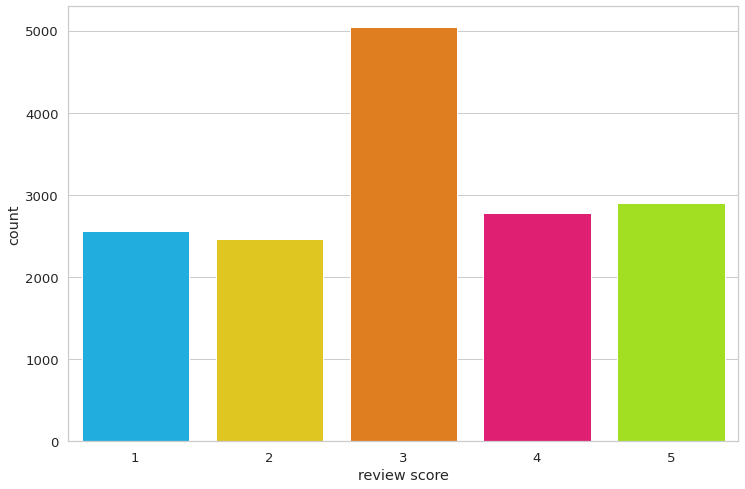

In [0]:
sns.countplot(df.score)
plt.xlabel('review score');

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

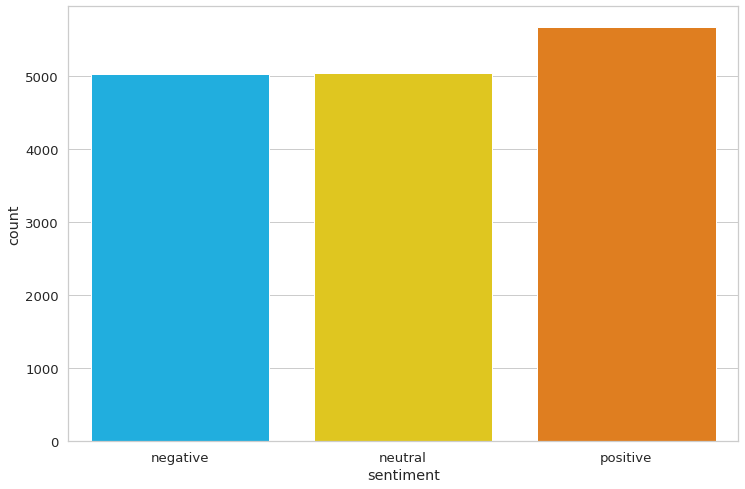

In [0]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

# adding a column sentiment to the df 
df['sentiment'] = df.score.apply(to_sentiment)

class_names = ['negative', 'neutral', 'positive']

# now check for imbalance
ax = sns.countplot(df.sentiment)
plt.xlabel('sentiment')
ax.set_xticklabels(class_names);

## Data Preprocessing

- Add special tokens to separate sentences 
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


### Tokenization
> You can use a cased and uncased version of BERT and tokenizer. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

# tokenize using Bert Tokenizer
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


#### Special Tokens

`[SEP]` - marker for ending of a sentence


In [0]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [0]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Padding Token

In [0]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

 `[UNK]` (unknown) token:

In [0]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### Tokenize along with padding and special tokens
Adding special tokens and padding can be done using encode_plus() method

In [0]:
encoding = tokenizer.encode_plus(
                sample_txt,
                max_length=32,
                add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                return_token_type_ids=False,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt',  # Return PyTorch tensors
                )

print(encoding.keys())

print(len(encoding['input_ids'][0]))
print(encoding['input_ids'])

print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])

# Convert back to tokens
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

dict_keys(['input_ids', 'attention_mask'])
32
tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
32
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
['[CLS]', 'When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


### Choose Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

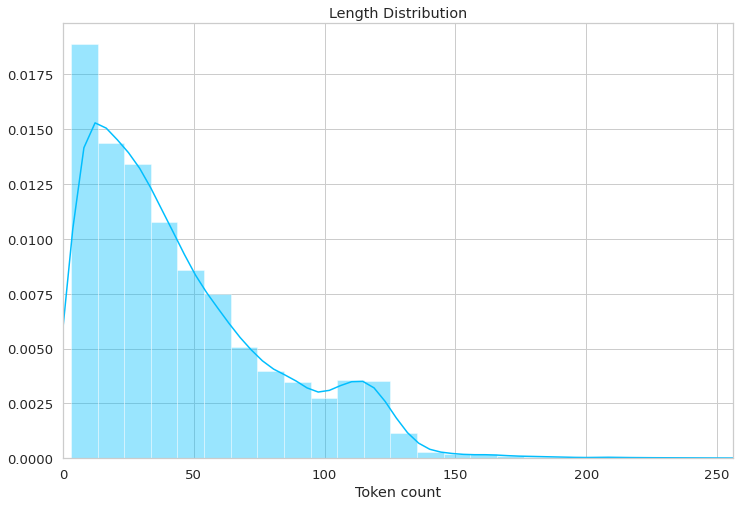

In [0]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

# Plot the length distribution
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.title('Length Distribution');

## Generate Dataset

In [0]:
class gp_review_dataset(Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.reviews = df.content.to_numpy()
        self.targets = df.sentiment.to_numpy()
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)

    def get_review(self, i):
        return str(self.reviews[i])
  
    def __getitem__(self, i):
        review = str(self.reviews[i])
        target = self.targets[i]

        # encode the reviews
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        data_dict = {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)}

        return data_dict

dataset = gp_review_dataset(df, tokenizer, max_len = 160)

print('Total Reviews: {}'.format(len(dataset)))

data = dataset[0]
review = dataset.get_review(0)
print(review)
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'])

Total Reviews: 15746
Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.
torch.Size([160])
torch.Size([160])
tensor(0)


## Generate Dataloaders

In [0]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=4)

batch = next(iter(train_loader))
print(batch['input_ids'].shape)
print(batch['attention_mask'].shape)
print(batch['targets'].shape)

The length of Train set is 14172
The length of Valid set is 1574
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Network (BERT)

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it.

In [0]:
bert_model = BertModel.from_pretrained('bert-base-cased')

# do a test forward prop
hidden_state, output = bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
print(hidden_state.shape)
print(output.shape)
print(bert_model.config.hidden_size)

torch.Size([16, 160, 768])
torch.Size([16, 768])
768


`output` can be thought of as a pooled version of the hidden state

In [0]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        hidden_state, output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output)
        output = self.classifier(output)
        return output

network = SentimentClassifier(len(class_names)).to(device)

## Helper functions for training 

In [0]:
def print_overwrite(step, total_step, loss, acc, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f  Accuracy: %.4f" % (step, total_step, loss, acc))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f  Accuracy: %.4f" % (step, total_step, loss, acc))
    sys.stdout.flush()

# function to find the accuracy
def find_acc(pred, label):
    correct = pred.argmax(dim = 1).eq(label)
    accuracy = correct.to(torch.float32).mean().item() * 100
    return accuracy

def train(network, criterion, optimizer, scheduler):
    network = network.train()
    loss = []
    accuracy = []
    
    for step, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        logits = network(input_ids=input_ids, attention_mask=attention_mask)

        optimizer.zero_grad()

        loss_step = criterion(logits, targets)
        acc_step = find_acc(logits, targets)

        loss_step.backward()
        nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        print_overwrite(step, len(train_loader), loss_step, acc_step, 'train')

        loss.append(loss_step.item())
        accuracy.append(acc_step)

    return np.mean(loss), np.mean(accuracy)

def validate(network, criterion):
    network = network.eval()
    loss = []
    accuracy = []
    
    with torch.no_grad():
        for step, batch in enumerate(valid_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            logits = network(input_ids=input_ids, attention_mask=attention_mask)

            loss_step = criterion(logits, targets)
            acc_step = find_acc(logits, targets)

            print_overwrite(step, len(valid_loader), loss_step, acc_step, 'valid')

            loss.append(loss_step.item())
            accuracy.append(acc_step)

    return np.mean(loss), np.mean(accuracy)

## Training Loop

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps.

The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [0]:
num_epochs = 10
acc_max = 0

# WandB – Initialize a new run
wandb.init(name='BERT', entity="arkalim", project="personal")

optimizer = AdamW(network.parameters(), lr=2e-5, correct_bias=False)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps= len(train_loader) * num_epochs)

criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(1,num_epochs+1):

    loss_train, acc_train = train(network, criterion, optimizer, scheduler)
    loss_valid, acc_valid = validate(network, criterion)
        
    sys.stdout.write('\r')
    sys.stdout.flush()
    print('\n----------------------------------------------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Train Acc: {:.4f}  Valid Loss: {:.4f}  Valid Acc: {:.4f}'.format(epoch, loss_train, acc_train, loss_valid, acc_valid))
    print('----------------------------------------------------------------------------------------')

    if acc_valid > acc_max:
        acc_max = acc_valid
        torch.save(network.state_dict(), 'sentiment_analysis_bert.pth') 
        print("\nMaximum validation Acc of {} at epoch {}/{}".format(acc_max, epoch, num_epochs))
        print('Model Saved')
    
    wandb.log({
        "Epoch": epoch,
        "Train Loss": loss_train,
        "Train Acc": acc_train,
        "Valid Loss": loss_valid,
        "Valid Acc": acc_valid,
        "Max Valid Acc": acc_max})


----------------------------------------------------------------------------------------
Epoch: 1  Train Loss: 0.7200  Train Acc: 67.6590  Valid Loss: 0.5758  Valid Acc: 75.9680
----------------------------------------------------------------------------------------

Maximum validation Acc of 75.96801350815127 at epoch 1/10
Model Saved

----------------------------------------------------------------------------------------
Epoch: 2  Train Loss: 0.4111  Train Acc: 84.1446  Valid Loss: 0.4923  Valid Acc: 82.7441
----------------------------------------------------------------------------------------

Maximum validation Acc of 82.74410776417665 at epoch 2/10
Model Saved

----------------------------------------------------------------------------------------
Epoch: 3  Train Loss: 0.2168  Train Acc: 93.0070  Valid Loss: 0.5502  Valid Acc: 85.1221
----------------------------------------------------------------------------------------

Maximum validation Acc of 85.12205391219167 at epoch 

KeyboardInterrupt: ignored

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [0]:
review_text = "The movie is not good."

encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=160,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = F.softmax(network(input_ids, attention_mask), dim = 1)
confidence, prediction = torch.max(output, dim=1)

print('Sentiment : %s  Confidence: %.2f' %(class_names[prediction], confidence * 100))

Sentiment : negative  Confidence: 99.99
